In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max.rows', 150)
pd.set_option('display.max.columns', 150)

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from tqdm import tqdm_notebook as tqdm

from category_encoders import OrdinalEncoder, OneHotEncoder
# import eli5
# from eli5.sklearn import PermutationImportance

from scipy.stats import randint, uniform

In [44]:
from xgboost import XGBRegressor

In [48]:
import xgboost as xgb

In [2]:
trainval = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
structures = pd.read_csv('./data/structures.csv')
dipole = pd.read_csv('./data/dipole_moments.csv')
contrib = pd.read_csv('./data/scalar_coupling_contributions.csv')
magnetic = pd.read_csv('./data/magnetic_shielding_tensors.csv')
mulliken = pd.read_csv('./data/mulliken_charges.csv')
potential_energy = pd.read_csv('./data/potential_energy.csv')
# test_mulliken = pd.read_csv('mulliken_charges_test_set.csv')

## Reduce Memory Function

In [3]:
def reduce_mem_usage(df, verbose=True):
    """
    This function reduces the numeric to the least possible numeric type that fits the data so 
    memory usage during transforming and training will be reduced.
    Taken from: https://www.kaggle.com/todnewman/keras-neural-net-for-champs
    
    Han
    Parameters:
    ===========
    dataframe: input dataframe 
    verbose: verbose mode, default True.
    Output:
    ===========
    dataframe: dataframe with numeric columns types changed to the least possible size
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Create features on structures

In [5]:
# %%time
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}



Calculating bonds



Counting and condensing bonds


,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,1,1.091953
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.80,3,1.017195
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.43,1,1.017190
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.43,1,1.017187
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.43,1,1.017208
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.78,2,0.962107


## Merge structures function

In [6]:
def merge_train_structures(train, structures, dip_mom, pot_energ):
  
    """This function is used to merge the structures dataset to the 
     original train dataset

     Parameters:
     ===========
       train: train dataframe
       structures: structures dataframe.

     Output:
       ===========
       dataframe: merged dataframe
     """

    structures = structures.rename({'atom_index': 'atom_index_0',
                                    'x':'x_0', 'y':'y_0', 'z':'z_0',
                                    'atom':'atom_0'}, axis=1)

    merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])

    structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)

    merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])

    structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
    
    dip_mom = dip_mom.rename({'X':'X_dipm', 'Y':'Y_dipm', 'Z':'Z_dipm'}, axis=1)

    merged_2 = pd.merge(merged_1, dip_mom, on=['molecule_name',])
    
    merged_3 = pd.merge(merged_2, pot_energ, on=['molecule_name',])

    assert train.shape[0] == merged.shape[0]

    return merged_3

In [7]:
merged = merge_train_structures(trainval, structures, dipole, potential_energy)

In [8]:
assert len(merged) == len(trainval)

In [10]:
merged.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,2.2,0.43,1,1.091948,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.0,0.0,0.0,-40.52368


In [11]:
# df['Total charge'] = df['Total day charge'] + df['Total eve charge'] + \
#                      df['Total night charge'] + df['Total intl charge']

In [12]:
merged['enrg_per_bnd'] = merged['potential_energy'] / (merged['n_bonds_x'] + merged['n_bonds_y'])

In [13]:
merged.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,2.2,0.43,1,1.091948,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.0,0.0,0.0,-40.52368,-20.261840
5,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946,0.0,0.0,0.0,-40.52368,-20.261840
6,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946,0.0,0.0,0.0,-40.52368,-20.261840
7,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948,0.0,0.0,0.0,-40.52368,-20.261840
8,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948,0.0,0.0,0.0,-40.52368,-20.261840
9,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948,0.0,0.0,0.0,-40.52368,-20.261840


In [14]:
mulliken = mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_1'])
assert len(merged) == len(trainval)

## Feature Engineering

In [15]:
%%time
# This block is SPPED UP

train_p_0 = merged[['x_0', 'y_0', 'z_0']].values
train_p_1 = merged[['x_1', 'y_1', 'z_1']].values
# test_p_0 = test[['x_0', 'y_0', 'z_0']].values
# test_p_1 = test[['x_1', 'y_1', 'z_1']].values

merged['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
# test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
assert len(merged) == len(trainval)

CPU times: user 1.37 s, sys: 1.23 s, total: 2.6 s
Wall time: 1.2 s


In [16]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736,0.133921,-0.535689,1.091953
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736,0.133922,-0.535689,1.091952
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736,0.133923,-0.535689,1.091946
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,2.2,0.43,1,1.091948,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.0,0.0,0.0,-40.52368,-8.104736,0.133923,-0.535689,1.091948
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.0,0.0,0.0,-40.52368,-20.261840,0.133921,0.133922,1.783120


In [21]:
# %%time

external_data_0 = pd.DataFrame(data={
    'atom_0': ['C', 'H', 'N', 'O', 'F'],
    'atom_0_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_0': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_0': [4, 1, 5, 6, 7]
})
external_data_1 = pd.DataFrame(data={
    'atom_1': ['C', 'H', 'N', 'O', 'F'],
    'atom_1_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_1': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_1': [4, 1, 5, 6, 7]
})

def create_features(df):
    df['bond'] = df['type'].str[2:]
    df['j_type'] = df['type'].str[:2]
    df['distance'] = ((df['x_1'].values - df['x_0'].values)**2 + 
                    (df['y_1'].values - df['y_0'].values)**2 + 
                    (df['z_1'].values - df['z_0'].values)**2)** 0.5
    df['mu_0'] = np.sqrt(df['x_0'].values**2 + df['y_0'].values**2 + df['z_0'].values**2)
    df['mu_1'] = np.sqrt(df['x_1'].values**2 + df['y_1'].values**2 + df['z_1'].values**2)
    df = df.merge(external_data_0, on='atom_0', how='left')
    df = df.merge(external_data_1, on='atom_1', how='left')
    df['delta_en'] = (df['atom_0_en'] - df['atom_1_en']).abs()
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df['molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df['molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df['molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df['molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df['molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df['molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df['molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df['molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df['molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df['molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df['molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df['molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df['molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df['molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df['molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df['molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df['molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df['molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df['molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df['molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df['molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df['molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df['molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df['molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df['molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df['molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df['molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df['molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df['molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df['molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df['molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df['molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df['molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df['molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
#     df['molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
#     df['molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
#     df['molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
#     df['molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
#     df['molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
#     df['molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
#     df['molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
#     df['molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
#     df['molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    df = reduce_mem_usage(df)
    return df

In [18]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df_train):
    #I apologize for my poor coding skill. Please make the better one.
    df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
#     df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df_train = map_atom_info(df_train,df_temp, atom_idx)
        df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                            'distance_closest': f'distance_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})
    df_train = reduce_mem_usage(df_train)
    return df_train


In [22]:
# %%time
merged = create_features(merged)
assert len(merged) == len(trainval)

Mem. usage decreased to 959.55 Mb (69.0% reduction)


In [23]:
# %%time
dtrain = create_closest(merged)

Mem. usage decreased to 1043.95 Mb (2.5% reduction)


In [24]:
assert len(dtrain) == len(trainval)

In [25]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    df = reduce_mem_usage(df)
    return df
    
merged = add_cos_features(dtrain)

Mem. usage decreased to 1088.38 Mb (0.0% reduction)


In [26]:
assert len(merged) == len(trainval)
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.0,0.0,0.0,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,0.728027,1.358398,0.272949,1.251380,1.463867,0.377930,0.182251,0.728027,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.345703,-0.746582,0.316406,1.091797,-0.000003,1.0,1.091797,0.000000,1.0,1.091797,-0.000007,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000007,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.0,0.0,0.0,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,0.300049,1.324219,0.237915,1.219147,1.447266,0.361816,0.206177,0.891602,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.399170,-0.692871,0.365479,1.091797,-0.000002,1.0,1.091797,0.000001,1.0,1.091797,-0.000005,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000005,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.0,0.0,0.0,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.776367,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,2,4,0.361328,1.261719,0.176025,1.162151,1.437500,0.352051,0.249023,0.635254,1.437500,0.345703,1.316406,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.488770,-0.603027,0.447510,1.091797,0.000003,1.0,1.091797,0.000007,1.0,1.09

In [27]:
merged['dip_cop_0'] = (3*(merged['cos_0']**2)-1) / 2
merged['dip_cop_1'] = (3*(merged['cos_1']**2)-1) / 2
merged['dip_cop_0_1'] = (3*(merged['cos_0_1']**2)-1) / 2

In [28]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,dip_cop_0,dip_cop_1,dip_cop_0_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.0,0.0,0.0,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,0.728027,1.358398,0.272949,1.251380,1.463867,0.377930,0.182251,0.728027,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.345703,-0.746582,0.316406,1.091797,-0.000003,1.0,1.091797,0.000000,1.0,1.091797,-0.000007,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000007,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.0,0.0,0.0,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,0.300049,1.324219,0.237915,1.219147,1.447266,0.361816,0.206177,0.891602,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.399170,-0.692871,0.365479,1.091797,-0.000002,1.0,1.091797,0.000001,1.0,1.091797,-0.000005,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000005,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.0,0.0,0.0,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.776367,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,2,4,0.361328,1.261719,0.176025,1.162151,1.437500,0.352051,0.249023,0.635254,1.437500,0.345703,1.316406,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,0.488770,-0.603027,0

## Scoring Function

In [29]:
groups = merged['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
  maes = (y_true - y_pred).abs().groupby(groups).mean()
  return np.log(maes.map(lambda x: max(x, floor))).mean()

## Splitting

In [30]:
trainval_1JHC = merged[merged['type'] == '1JHC']
trainval_1JHN = merged[merged['type'] == '1JHN']
trainval_2JHH = merged[merged['type'] == '2JHH']
trainval_2JHN = merged[merged['type'] == '2JHN']
trainval_2JHC = merged[merged['type'] == '2JHC']
trainval_3JHH = merged[merged['type'] == '3JHH']
trainval_3JHC = merged[merged['type'] == '3JHC']
trainval_3JHN = merged[merged['type'] == '3JHN']

In [54]:
trainval_1JHC.head(50)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,dip_cop_0,dip_cop_1,dip_cop_0_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8125,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.000000,0.000000,0.000000,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,0.728027,1.358398,0.272949,1.251380,1.463867,0.377930,0.182251,0.728027,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,0.0,1.0,0.345703,-0.746582,0.316406,1.091797,-0.000003,1.000000,1.091797,0.000000,1.000000,1.091797,-6.675720e-06,1.000000,0.000003,-1.091797,0.000003,1.091797,1.091797,-6.675720e-06,1.000000,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8125,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.000000,0.000000,0.000000,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,0.300049,1.324219,0.237915,1.219147,1.447266,0.361816,0.206177,0.891602,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,0.0,1.0,0.399170,-0.692871,0.365479,1.091797,-0.000002,1.000000,1.091797,0.000001,1.000000,1.091797,-5.245209e-06,1.000000,0.000003,-1.091797,0.000003,1.091797,1.091797,-5.245209e-06,1.000000,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8125,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.000000,0.000000,0.000000,-40.53125,-8.101562,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.776367,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,2,4,0.361328,1.261719,0.176025,1.162151,1.437500,0.352051,0.249023,0.635254,1.437500,0.345703,1.316406

In [31]:
train_1JHC, val_1JHC = train_test_split(trainval_1JHC, shuffle=False, random_state=47)

train_1JHC_molecules = train_1JHC['molecule_name'].unique()
val_1JHC_molecules = np.delete(val_1JHC['molecule_name'].unique(), 0)

train_1JHC = train_1JHC[train_1JHC['molecule_name'].isin(train_1JHC_molecules)]
val_1JHC = val_1JHC[val_1JHC['molecule_name'].isin(val_1JHC_molecules)]

In [32]:
train_1JHN, val_1JHN = train_test_split(trainval_1JHN, shuffle=False, random_state=47)

train_1JHN_molecules = train_1JHN['molecule_name'].unique()
val_1JHN_molecules = np.delete(val_1JHN['molecule_name'].unique(), 0)

train_1JHN = train_1JHN[train_1JHN['molecule_name'].isin(train_1JHN_molecules)]
val_1JHN = val_1JHN[val_1JHN['molecule_name'].isin(val_1JHN_molecules)]

In [33]:
train_2JHH, val_2JHH = train_test_split(trainval_2JHH, shuffle=False, random_state=47)

train_2JHH_molecules = train_2JHH['molecule_name'].unique()
val_2JHH_molecules = np.delete(val_2JHH['molecule_name'].unique(), 0)

train_2JHH = train_2JHH[train_2JHH['molecule_name'].isin(train_2JHH_molecules)]
val_2JHH = val_2JHH[val_2JHH['molecule_name'].isin(val_2JHH_molecules)]

In [57]:
train_2JHH.head(50)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,dip_cop_0,dip_cop_1,dip_cop_0_1
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,0.000000,0.000000,0.000000,-40.53125,-20.265625,0.133911,0.133911,1.783203,HH,2J,1.783203,0.006702,1.779297,2.199219,1.007812,1,2.199219,1.007812,1,0.0,10,1.506836,1.091797,1.783203,4,1,0.728027,1.358398,-0.104980,0.928268,1.463867,0.000000,0.182251,0.728027,1.610352,-0.172729,0.903320,1.783203,0.000037,1.000000,1.091797,-0.691406,0.612305,0.345703,-1.437500,0.193848,1.783203,0.000000e+00,1.000000,1.783203,0.000000e+00,1.000000,1.783203,0.000000e+00,1.000000,NaN,NaN,NaN,1.783203,1.783203,0.000000e+00,1.000000,0.000014,-1.783203,0,1.091797,-0.012695,1.085938,0.008003,0.0,1.091797,-0.012695,1.085938,0.008003,1.091797,1.091797,-0.333496,-1.333008,1.333984,2.166016,2.167969,-0.333252
5,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,0.000000,0.000000,0.000000,-40.53125,-20.265625,0.133911,0.133911,1.783203,HH,2J,1.783203,0.006702,1.776367,2.199219,1.007812,1,2.199219,1.007812,1,0.0,10,1.506836,1.091797,1.783203,4,2,0.728027,1.358398,-0.088745,0.938673,1.463867,0.016220,0.182251,0.728027,1.610352,-0.172852,0.903320,1.783203,0.000009,1.000000,1.091797,-0.691406,0.612305,0.345703,-1.437500,0.193848,1.783203,5.066395e-06,1.000000,1.783203,1.019239e-05,1.000000,1.783203,0.000000e+00,1.000000,7.212162e-06,-1.783203,4.053116e-06,1.783203,1.783203,-2.771616e-05,1.000000,0.000014,-1.783203,0,1.091797,-0.012695,1.085938,0.008003,0.0,1.091797,-0.012695,1.085938,0.008003,1.091797,1.091797,-0.333252,-1.333008,1.333008,2.166016,2.166016,-0.333496
6,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,0.000000,0.000000,0.000000,-40.53125,-20.265625,0.133911,0.133911,1.783203,HH,2J,1.783203,1.779297,1.776367,2.199219,1.007812,1,2.199219,1.007812,

In [34]:
train_2JHN, val_2JHN = train_test_split(trainval_2JHN, shuffle=False, random_state=47)

train_2JHN_molecules = train_2JHN['molecule_name'].unique()
val_2JHN_molecules = np.delete(val_2JHN['molecule_name'].unique(), 0)

train_2JHN = train_2JHN[train_2JHN['molecule_name'].isin(train_2JHN_molecules)]
val_2JHN = val_2JHN[val_2JHN['molecule_name'].isin(val_2JHN_molecules)]

In [55]:
train_2JHN.head(20)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,dip_cop_0,dip_cop_1,dip_cop_0_1
18,18,dsgdb9nsd_000005,2,1,2JHN,5.183594,H,-0.027802,2.199219,0.014153,2.199219,0.429932,1,1.066406,N,0.002310,-0.019165,0.001928,3.039062,0.799805,1,1.151367,0.000000,0.000000,-2.894531,-93.4375,-46.71875,0.238159,-0.188477,2.218750,HN,2J,2.218750,2.199219,0.019394,2.199219,1.007812,1,3.039062,14.007812,5,0.839844,2,1.642578,1.066406,2.218750,2,1,0.011055,0.556641,0.575684,-29.055043,1.132812,1.151367,0.814453,0.004490,1.642578,-0.575684,0.740234,2.218750,0.000000,1.000000,1.066406,-1.151367,0.480713,0.814453,-1.404297,0.367188,2.218750,0.000000,1.000000,2.218750,0.000000,1.000000,2.218750,0.000000,1.000000,NaN,NaN,NaN,2.218750,2.218750,0.000000,1.000000,NaN,NaN,0,1.066406,-0.013321,1.132812,0.008278,NaN,NaN,NaN,NaN,NaN,1.066406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,104,dsgdb9nsd_000012,5,0,2JHN,15.515625,H,-0.961426,-0.475098,0.008072,2.199219,0.429932,1,1.109375,N,-0.025894,1.345703,0.008896,3.039062,0.799805,3,1.124023,-3.662109,0.705566,0.000900,-169.8750,-42.46875,0.072266,-0.463135,2.046875,HN,2J,2.046875,1.072266,1.346680,2.199219,1.007812,1,3.039062,14.007812,5,0.839844,9,1.809570,1.004883,2.960938,2,3,0.051178,0.666992,-0.678711,0.495638,1.345703,0.000000,0.959961,0.005436,1.578125,-0.468994,0.770996,2.046875,0.000000,1.000000,1.109375,-0.937988,0.541992,0.663574,-1.383789,0.323975,1.353516,-0.694336,0.661133,2.046875,0.000000,1.000000,1.004883,-1.041992,0.490723,0.601074,-1.446289,0.293701,1.353516,1.004883,-1.041992,0.490723,0.601074,-1.446289,1,1.109375,0.046478,-0.011742,0.001204,NaN,NaN,NaN,NaN,NaN,1.109375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,400,dsgdb9nsd_000032,6,0,2JHN,0.633789,H,0.489502,-0.408691,-0.896973,2.199219,0.429932,1,1.102539,N,-0.036072,1.487305,0.036774,3.039062,0.799805,3,1.165039,3.947266,1.653320,1.166016,-188.1250,-47.03125,0.137085,-0.495850,2.177734,HN,2J,2.177734,1.100586,1.488281,2.199219,1.007812,1,3.039062,14.007812,5,0.839844,20,2.130859,1.014648,3.285156,5,4,1.214844,-0.062622,-1.549805,-0.042105,1.487305,0.000000,0.936035,0.377930,2.048828,-0.128540,0.940918,

In [35]:
train_2JHC, val_2JHC = train_test_split(trainval_2JHC, shuffle=False, random_state=47)

train_2JHC_molecules = train_2JHC['molecule_name'].unique()
val_2JHC_molecules = np.delete(val_2JHC['molecule_name'].unique(), 0)

train_2JHC = train_2JHC[train_2JHC['molecule_name'].isin(train_2JHC_molecules)]
val_2JHC = val_2JHC[val_2JHC['molecule_name'].isin(val_2JHC_molecules)]

In [36]:
train_3JHH, val_3JHH = train_test_split(trainval_3JHH, shuffle=False, random_state=47)

train_3JHH_molecules = train_3JHH['molecule_name'].unique()
val_3JHH_molecules = np.delete(val_3JHH['molecule_name'].unique(), 0)

train_3JHH = train_3JHH[train_3JHH['molecule_name'].isin(train_3JHH_molecules)]
val_3JHH = val_3JHH[val_3JHH['molecule_name'].isin(val_3JHH_molecules)]

In [37]:
train_3JHC, val_3JHC = train_test_split(trainval_3JHC, shuffle=False, random_state=47)

train_3JHC_molecules = train_3JHC['molecule_name'].unique()
val_3JHC_molecules = np.delete(val_3JHC['molecule_name'].unique(), 0)

train_3JHC = train_3JHC[train_3JHC['molecule_name'].isin(train_3JHC_molecules)]
val_3JHC = val_3JHC[val_3JHC['molecule_name'].isin(val_3JHC_molecules)]

In [38]:
train_3JHN, val_3JHN = train_test_split(trainval_3JHN, shuffle=False, random_state=47)

train_3JHN_molecules = train_3JHN['molecule_name'].unique()
val_3JHN_molecules = np.delete(val_3JHN['molecule_name'].unique(), 0)

train_3JHN = train_3JHN[train_3JHN['molecule_name'].isin(train_3JHN_molecules)]
val_3JHN = val_3JHN[val_3JHN['molecule_name'].isin(val_3JHN_molecules)]

In [56]:
train_3JHN.head(20)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,dip_cop_0,dip_cop_1,dip_cop_0_1
77,73,dsgdb9nsd_000010,3,2,3JHN,0.880859,H,1.001953,1.861328,0.002455,2.199219,0.429932,1,1.093750,N,0.017654,-1.144531,-0.004204,3.039062,0.799805,1,1.155273,3.826172,0.000000,-0.000100,-132.750,-66.37500,0.176392,-0.285400,3.162109,HN,3J,3.162109,2.113281,1.144531,2.199219,1.007812,1,3.039062,14.007812,5,0.839844,12,2.033203,1.093750,3.162109,5,3,0.293945,0.802734,1.947266,-0.701237,1.844727,2.990234,1.324219,0.627930,1.982422,-1.180664,0.626953,3.162109,0.000000,1.000000,1.093750,-2.068359,0.345703,0.755371,-2.406250,0.238892,3.162109,0.000051,1.000000,3.162109,0.000125,1.000000,3.162109,0.000000,1.000000,0.000066,-3.162109,0.000021,3.162109,3.162109,0.000000,1.000000,0.000066,-3.162109,0,1.093750,-0.017883,1.466797,0.010117,NaN,NaN,NaN,NaN,NaN,1.092773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,78,dsgdb9nsd_000010,4,2,3JHN,0.880859,H,-0.543945,1.844727,-0.870605,2.199219,0.429932,1,1.093750,N,0.017654,-1.144531,-0.004204,3.039062,0.799805,1,1.155273,3.826172,0.000000,-0.000100,-132.750,-66.37500,0.176270,-0.285400,3.162109,HN,3J,3.162109,2.111328,1.144531,2.199219,1.007812,1,3.039062,14.007812,5,0.839844,12,2.033203,1.093750,3.162109,4,3,0.264160,0.541992,1.686523,-0.473586,1.834961,2.980469,1.373047,0.451172,2.033203,-1.128906,0.643066,3.162109,0.000000,1.000000,1.093750,-2.070312,0.345703,0.862305,-2.300781,0.272705,3.162109,-0.000074,1.000000,3.162109,0.000000,1.000000,3.162109,-0.000125,1.000000,0.000066,-3.162109,0.000021,3.162109,3.162109,-0.000125,1.000000,0.000066,-3.162109,0,1.093750,-0.017883,1.466797,0.010117,NaN,NaN,NaN,NaN,NaN,1.093750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,82,dsgdb9nsd_000010,5,2,3JHN,0.880859,H,-0.526855,1.834961,0.904785,2.199219,0.429932,1,1.093750,N,0.017654,-1.144531,-0.004204,3.039062,0.799805,1,1.155273,3.826172,0.000000,-0.000100,-132.750,-66.37500,0.176270,-0.285400,3.162109,HN,3J,3.162109,2.113281,1.144531,2.199219,1.007812,1,3.039062,14.007812,5,0.839844,12,2.033203,1.093750,3.162109,3,3,0.017807,0.110962,1.255859,-0.096969,1.466797,2.611328,1.308594,0.007175,2.1191

## X_train, y_train, X_val, y_val

In [39]:
new_features_1 = ['EN_x', 'rad_x', 'n_bonds_x', 'bond_lengths_mean_x', 'X_dipm', 'Y_dipm', 'Z_dipm', 'potential_energy', 'enrg_per_bnd', 'EN_y', 'rad_y', 'n_bonds_y', 
                     'bond_lengths_mean_y','molecule_couples', 'molecule_dist_mean','molecule_dist_min', 'molecule_dist_max']
new_features_2 = ['atom_0_couples_count', 'atom_1_couples_count', 'molecule_atom_index_0_x_1_std', 
                  'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_mean_diff', 
                  'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
                  'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std' ]
new_features_3 = ['molecule_atom_index_0_z_1_std',
                   'molecule_atom_index_0_dist_mean',
                   'molecule_atom_index_0_dist_mean_diff',
                   'molecule_atom_index_0_dist_mean_div',
                   'molecule_atom_index_0_dist_max',
                   'molecule_atom_index_0_dist_max_diff',
                   'molecule_atom_index_0_dist_max_div',
                   'molecule_atom_index_0_dist_min',
                   'molecule_atom_index_0_dist_min_diff',
                   'molecule_atom_index_0_dist_min_div',
                   'molecule_atom_index_0_dist_std',
                   'molecule_atom_index_0_dist_std_diff',
                   'molecule_atom_index_0_dist_std_div',
                   'molecule_atom_index_1_dist_mean',
                   'molecule_atom_index_1_dist_mean_diff',
                   'molecule_atom_index_1_dist_mean_div',
                   'molecule_atom_index_1_dist_max',
                   'molecule_atom_index_1_dist_max_diff',
                   'molecule_atom_index_1_dist_max_div',
                   'molecule_atom_index_1_dist_min',
                   'molecule_atom_index_1_dist_min_diff',
                   'molecule_atom_index_1_dist_min_div',
                   'molecule_atom_index_1_dist_std',
                   'molecule_atom_index_1_dist_std_diff',
                   'molecule_atom_index_1_dist_std_div',
                   'molecule_atom_1_dist_mean',
                   'molecule_atom_1_dist_min',
                   'molecule_atom_1_dist_min_diff',
                   'molecule_atom_1_dist_min_div',
                   'molecule_atom_1_dist_std',
                   'molecule_atom_1_dist_std_diff']

new_features_4 = ['atom_index_closest_0',
                   'dist_y',
                   'x_closest_0',
                   'y_closest_0',
                   'z_closest_0',
                   'atom_index_closest_1',
                   'dist',
                   'x_closest_1',
                   'y_closest_1',
                   'z_closest_1',
                   'distance_0',
                   'distance_1',
                   'cos_0_1',
                   'cos_0',
                   'cos_1',
                   'dip_cop_0', 
                   'dip_cop_1',
                   'dip_cop_0_1'
                 ]


features = ['atom_index_0', 'atom_index_1', 'distance', 'atom_0_en',
            'atom_1_en', 'mu_0', 'mu_1', 'mulliken_charge_0',
            'mulliken_charge_1', 'x_0', 'x_1', 'y_0', 'y_1', 'z_0', 'z_1'] + new_features_1 + new_features_2 + new_features_3 + new_features_4

drop_feat = [
    'molecule_atom_index_0_x_1_std',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_0_z_1_std',
    'molecule_atom_index_0_dist_std',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_0_dist_std_div',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_1_dist_std_div',
    'molecule_atom_1_dist_std',
    'molecule_atom_1_dist_std_diff',
    'atom_index_closest_1', 'dist', 'x_closest_1',
    'y_closest_1', 'z_closest_1', 'distance_1',
    'cos_0_1', 'cos_0', 'cos_1', 'EN_y', 'n_bonds_x',
    'molecule_atom_index_0_dist_min_diff',
    'molecule_atom_index_0_dist_min_div','rad_y', 'EN_x', 'rad_x',
    'dist_y', 'atom_1_en', 'atom_0_en', 'z_closest_0']

for i in drop_feat:
  features.remove(i)

target = 'scalar_coupling_constant'

In [40]:
#full data
X_trainval_1JHC = trainval_1JHC[features]
X_trainval_1JHN = trainval_1JHN[features]
X_trainval_2JHH = trainval_2JHH[features]
X_trainval_2JHN = trainval_2JHN[features]
X_trainval_2JHC = trainval_2JHC[features]
X_trainval_3JHH = trainval_3JHH[features]
X_trainval_3JHC = trainval_3JHC[features]
X_trainval_3JHN = trainval_3JHN[features]

y_trainval_1JHC = trainval_1JHC[target]
y_trainval_1JHN = trainval_1JHN[target]
y_trainval_2JHH = trainval_2JHH[target]
y_trainval_2JHN = trainval_2JHN[target]
y_trainval_2JHC = trainval_2JHC[target]
y_trainval_3JHH = trainval_3JHH[target]
y_trainval_3JHC = trainval_3JHC[target]
y_trainval_3JHN = trainval_3JHN[target]

# split data
X_train_1JHC = train_1JHC[features]
X_train_1JHN = train_1JHN[features]
X_train_2JHH = train_2JHH[features]
X_train_2JHN = train_2JHN[features]
X_train_2JHC = train_2JHC[features]
X_train_3JHH = train_3JHH[features]
X_train_3JHC = train_3JHC[features]
X_train_3JHN = train_3JHN[features]

y_train_1JHC = train_1JHC[target]
y_train_1JHN = train_1JHN[target]
y_train_2JHH = train_2JHH[target]
y_train_2JHN = train_2JHN[target]
y_train_2JHC = train_2JHC[target]
y_train_3JHH = train_3JHH[target]
y_train_3JHC = train_3JHC[target]
y_train_3JHN = train_3JHN[target]


X_val_1JHC = val_1JHC[features]
X_val_1JHN = val_1JHN[features]
X_val_2JHH = val_2JHH[features]
X_val_2JHN = val_2JHN[features]
X_val_2JHC = val_2JHC[features]
X_val_3JHH = val_3JHH[features]
X_val_3JHC = val_3JHC[features]
X_val_3JHN = val_3JHN[features]

y_val_1JHC = val_1JHC[target]
y_val_1JHN = val_1JHN[target]
y_val_2JHH = val_2JHH[target]
y_val_2JHN = val_2JHN[target]
y_val_2JHC = val_2JHC[target]
y_val_3JHH = val_3JHH[target]
y_val_3JHC = val_3JHC[target]
y_val_3JHN = val_3JHN[target]

## Encoding

In [41]:
def encode(df):
  df = OrdinalEncoder.fit_transform(OrdinalEncoder(df), df)
  return df

def imp(df):
  df = SimpleImputer.fit_transform(SimpleImputer(df), df)
  return df

In [42]:
#split data
X_train_1JHC_encoded = encode(X_train_1JHC)
X_train_1JHN_encoded = encode(X_train_1JHN)
X_train_2JHH_encoded = encode(X_train_2JHH)
X_train_2JHC_encoded = encode(X_train_2JHC)
X_train_2JHN_encoded = encode(X_train_2JHN)
X_train_3JHH_encoded = encode(X_train_3JHH)
X_train_3JHC_encoded = encode(X_train_3JHC)
X_train_3JHN_encoded = encode(X_train_3JHN)

X_val_1JHC_encoded = encode(X_val_1JHC)
X_val_1JHN_encoded = encode(X_val_1JHN)
X_val_2JHH_encoded = encode(X_val_2JHH)
X_val_2JHN_encoded = encode(X_val_2JHN)
X_val_2JHC_encoded = encode(X_val_2JHC)
X_val_3JHH_encoded = encode(X_val_3JHH)
X_val_3JHC_encoded = encode(X_val_3JHC)
X_val_3JHN_encoded = encode(X_val_3JHN)

#full data
X_trainval_1JHC_encoded = encode(X_trainval_1JHC)
X_trainval_1JHN_encoded = encode(X_trainval_1JHN)
X_trainval_2JHH_encoded = encode(X_trainval_2JHH)
X_trainval_2JHC_encoded = encode(X_trainval_2JHC)
X_trainval_2JHN_encoded = encode(X_trainval_2JHN)
X_trainval_3JHH_encoded = encode(X_trainval_3JHH)
X_trainval_3JHC_encoded = encode(X_trainval_3JHC)
X_trainval_3JHN_encoded = encode(X_trainval_3JHN)

## Metrics

In [43]:
def custom_eval_metric(y_true, y_pred):
  return 'custom_eval_metric', np.log((y_true - y_pred).abs().mean()), False

def custom_score_metric(y_true, y_pred, sample_weight):
  return np.log((y_true - y_pred).abs().mean())

## 1JHC XGBoost

In [45]:
X_train_1JHC_encoded.head()

,atom_index_0,atom_index_1,distance,mu_0,mu_1,mulliken_charge_0,mulliken_charge_1,x_0,x_1,y_0,y_1,z_0,z_1,bond_lengths_mean_x,X_dipm,Y_dipm,Z_dipm,potential_energy,enrg_per_bnd,n_bonds_y,bond_lengths_mean_y,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,x_closest_0,y_closest_0,distance_0,dip_cop_0,dip_cop_1,dip_cop_0_1
0,1,0,1.091797,0.006702,1.085938,0.133911,-0.535645,0.002150,-0.012695,-0.006031,1.085938,0.001976,0.008003,1.091797,0.0,0.0,0.000000,-40.53125,-8.101562,4,1.091797,10,1.506836,1.091797,1.783203,4,4,1.358398,0.272949,1.463867,0.377930,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,1.091797,-0.000003,1.0,1.091797,0.000000,1.0,1.091797,-0.000007,1.0,1.091797,1.091797,-0.000007,1.0,0,-0.012695,1.085938,1.091797,NaN,NaN,NaN
1,2,0,1.091797,1.779297,1.085938,0.133911,-0.535645,1.011719,-0.012695,1.463867,1.085938,0.000277,0.008003,1.091797,0.0,0.0,0.000000,-40.53125,-8.101562,4,1.091797,10,1.506836,1.091797,1.783203,3,4,1.324219,0.237915,1.447266,0.361816,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,1.091797,-0.000002,1.0,1.091797,0.000001,1.0,1.091797,-0.000005,1.0,1.091797,1.091797,-0.000005,1.0,0,-0.012695,1.085938,1.091797,NaN,NaN,NaN
2,3,0,1.091797,1.776367,1.085938,0.133911,-0.535645,-0.541016,-0.012695,1.447266,1.085938,-0.876465,0.008003,1.091797,0.0,0.0,0.000000,-40.53125,-8.101562,4,1.091797,10,1.506836,1.091797,1.783203,2,4,1.261719,0.176025,1.437500,0.352051,1.437500,0.345703,1.316406,1.783203,0.691406,1.632812,1.091797,1.091797,0.000003,1.0,1.091797,0.000007,1.0,1.091797,0.000000,1.0,1.091797,1.091797,0.000000,1.0,0,-0.012695,1.085938,1.091797,NaN,NaN,NaN
3,4,0,1.091797,1.778320,1.085938,0.133911,-0.535645,-0.523926,-0.012695,1.437500,1.085938,0.906250,0.008003,1.091797,0.0,0.0,0.000000,-40.53125,-8.101562,4,1.091797,10,1.506836,1.091797,1.783203,1,4,1.085938,0.000000,1.085938,0.000000,1.091797,0.000000,1.000000,1.091797,0.000000,1.000000,1.091797,1.091797,0.000002,1.0,1.091797,0.000006,1.0,1.091797,-0.000001,1.0,1.091797,1.091797,-0.000001,1.0,0,-0.012695,1.085938,1.091797,NaN,NaN,NaN
17,2,0,1.066406,2.199219,1.132812,0.238159,-0.049652,-0.027802,-0.013321,2.199219,1.132812,0.014153,0.008278,1.066406,0.0,0.0,-2.894531,-93.43750,-31.140625,2,1.109375,2,1.642578,1.066406,2.218750,2,1,0.556641,-0.575684,1.132812,0.000000,1.642578,0.575684,1.540039,2.218750,1.151367,2.080078,1.066406,1.066406,0.000000,1.0,1.066406,0.000000,1.0,1.066406,0.000000,1.0,1.066406,1.066406,0.000000,1.0,0,-0.013321,1.132812,1.066406,NaN,NaN,NaN


In [46]:
xgb_model = XGBRegressor()

In [47]:
# xgb_model.fit(train_x,train_y)
xgb_model.fit(X_train_1JHC, y_train_1JHC)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

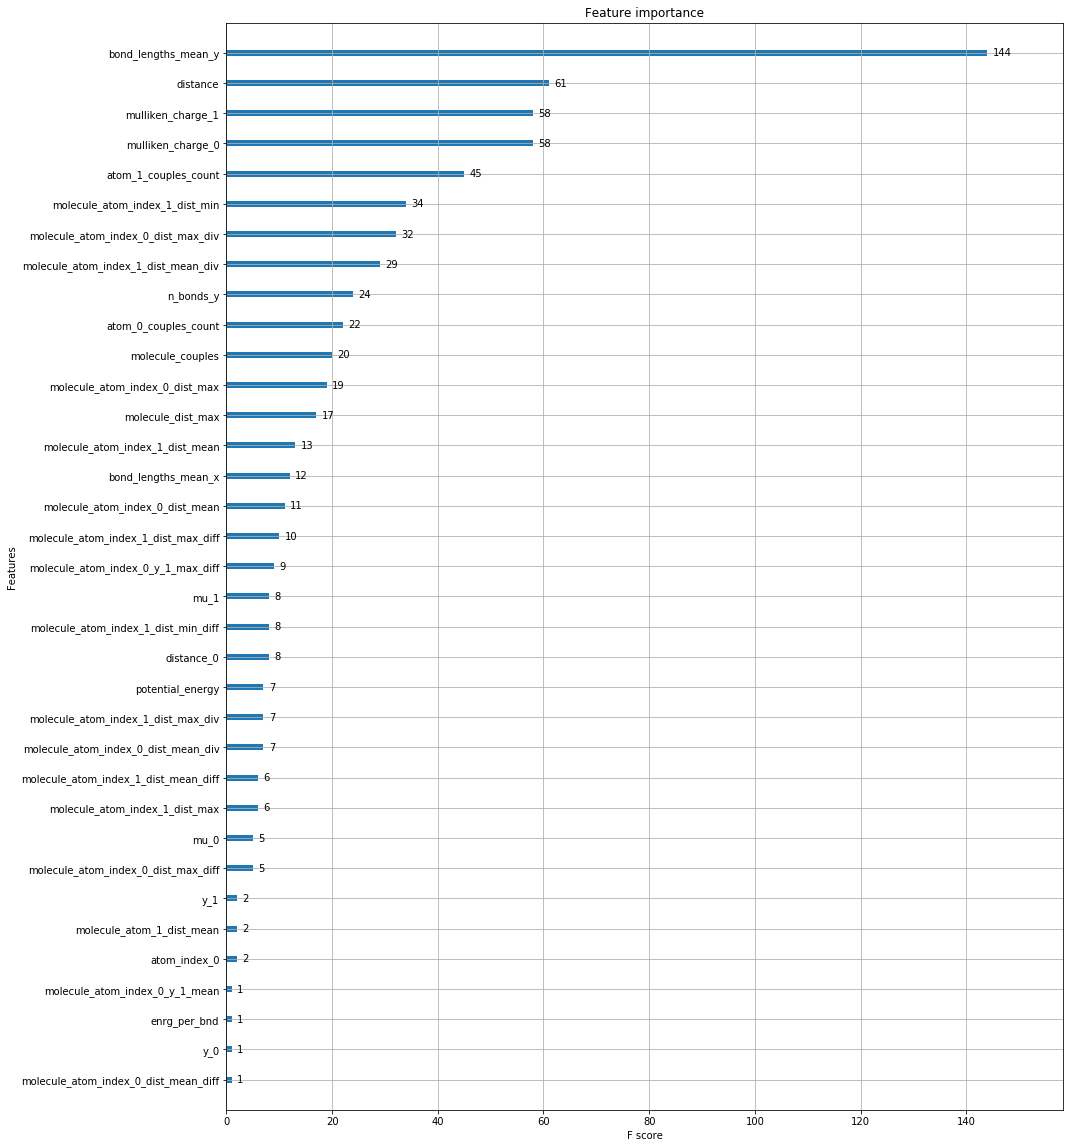

In [50]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [30, 50]
plt.show()

In [58]:
# X_train_1JHC.head(50)

In [60]:
xgb_model_2hh = XGBRegressor()

In [61]:
xgb_model_2hh.fit(X_train_2JHH, y_train_2JHH)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

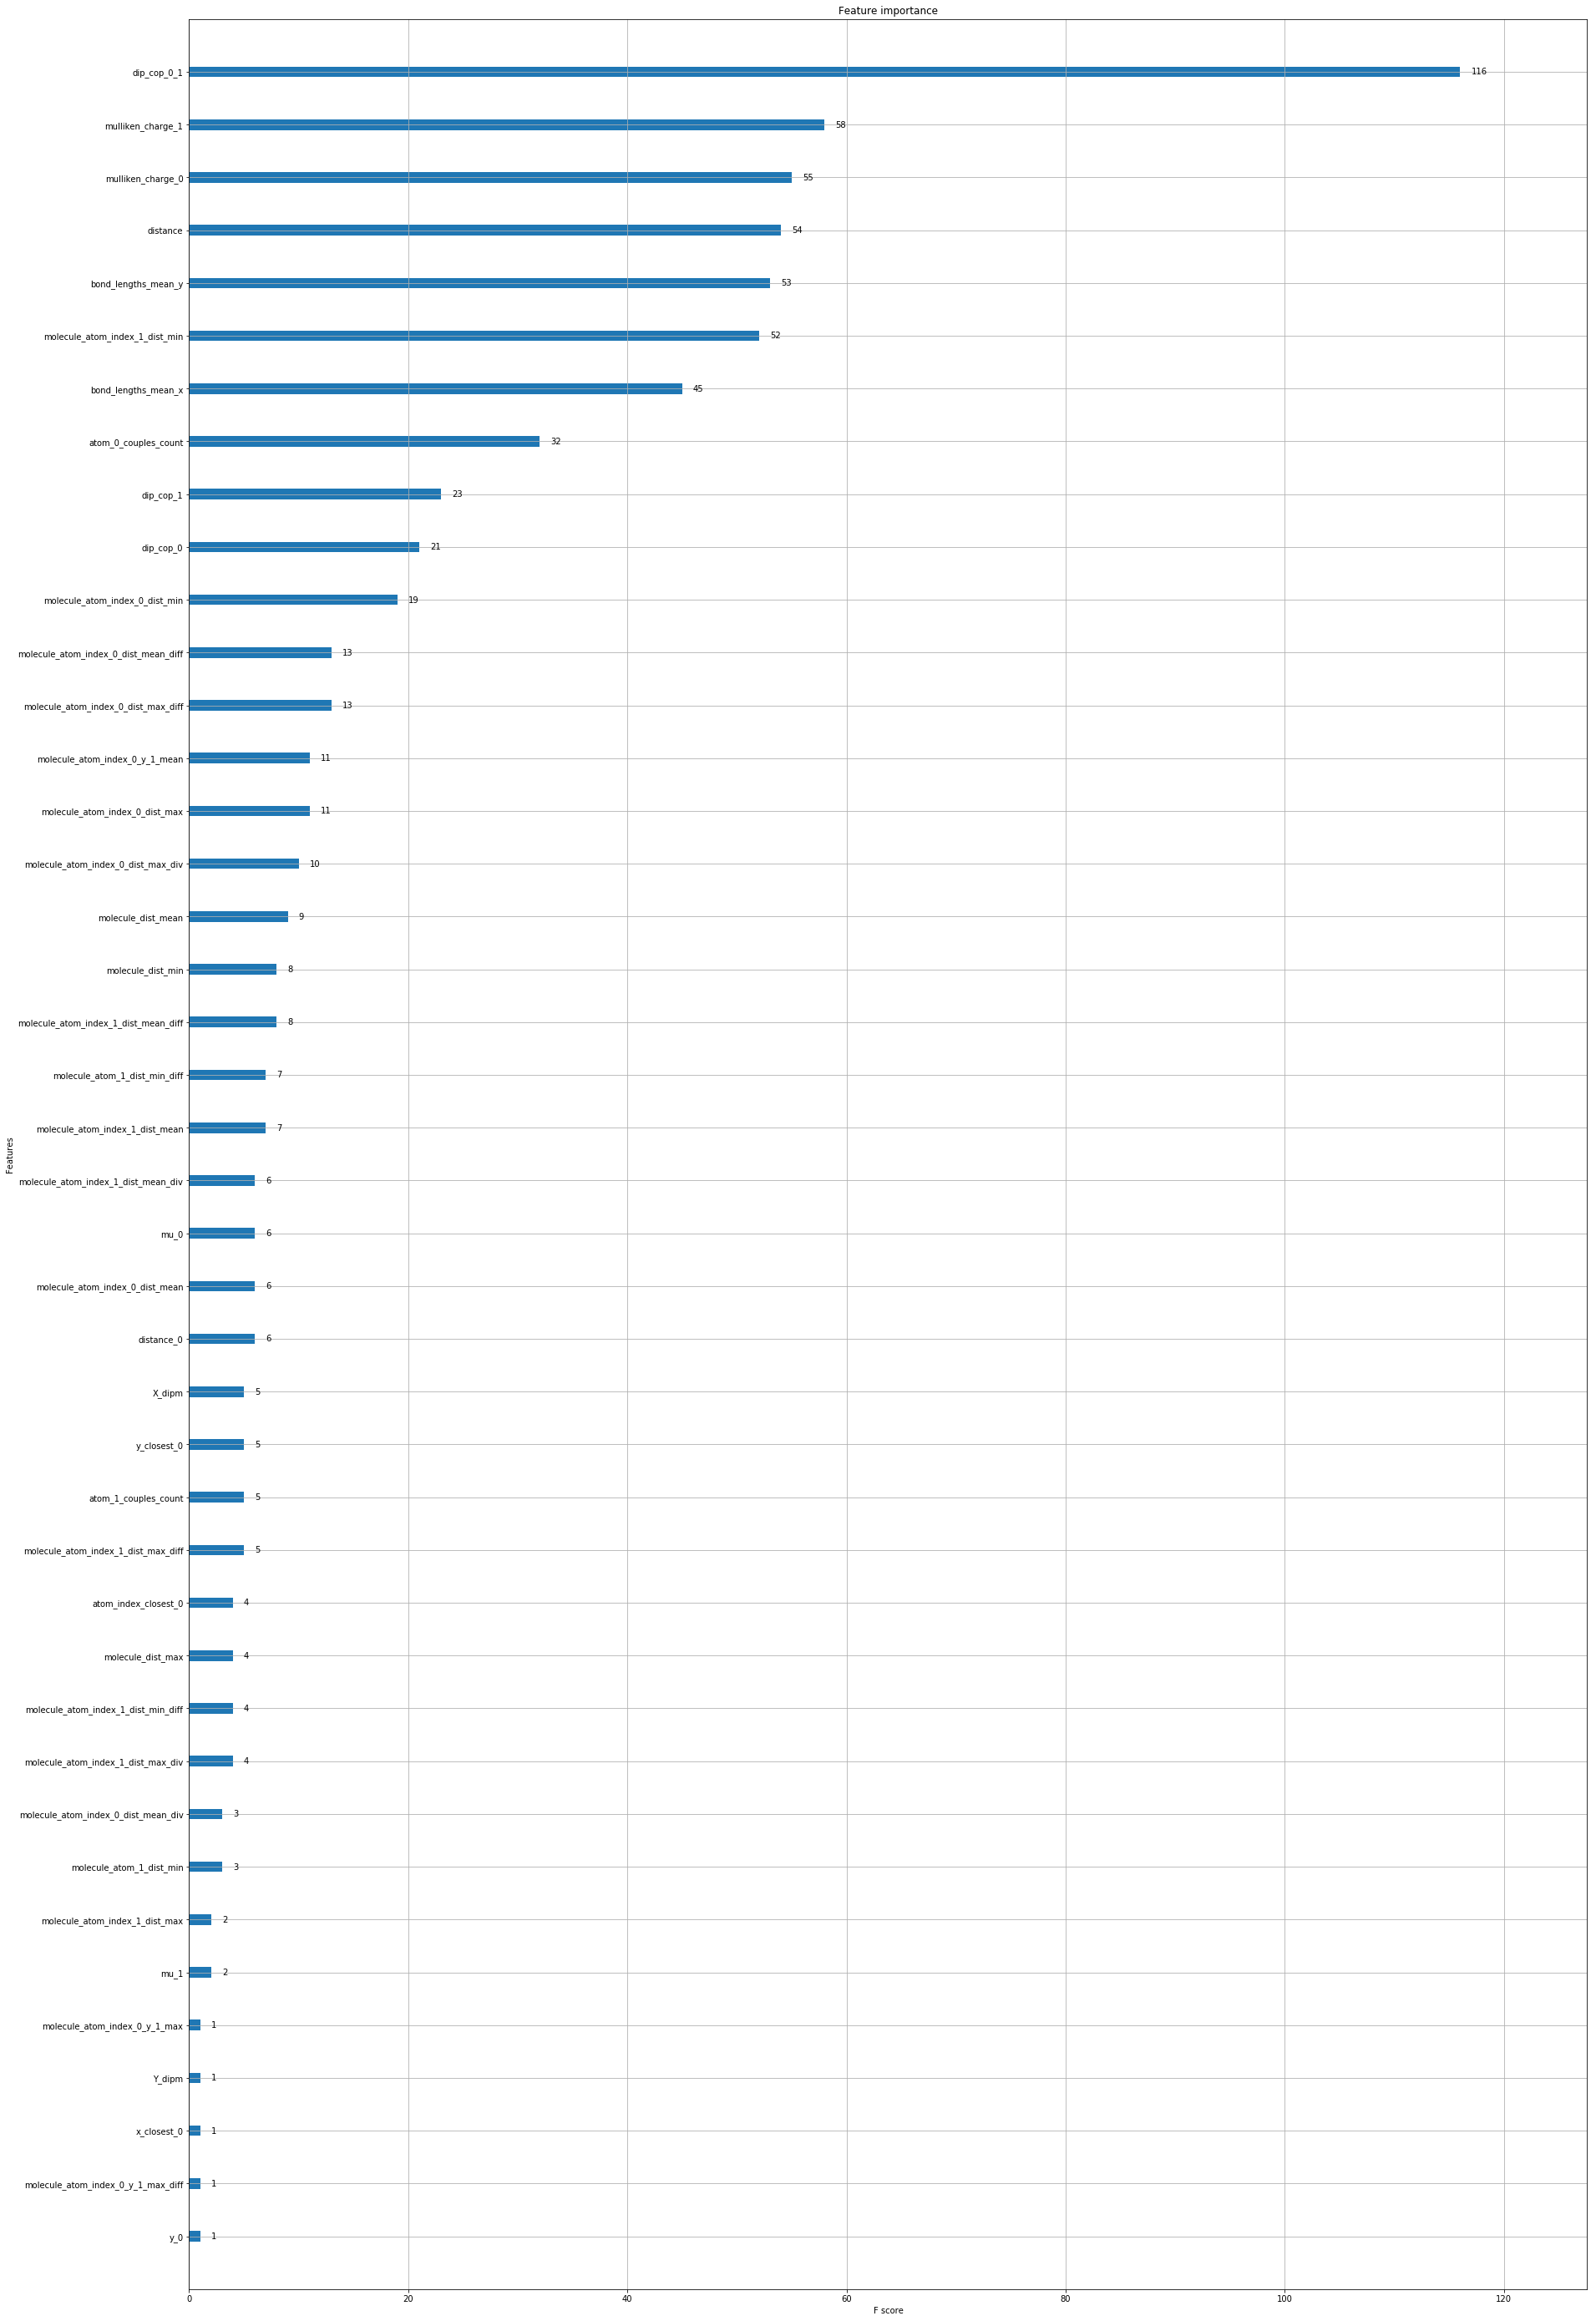

In [62]:
xgb.plot_importance(xgb_model_2hh)
plt.rcParams['figure.figsize'] = [30, 50]
plt.show()